[*********************100%***********************]  1 of 1 completed


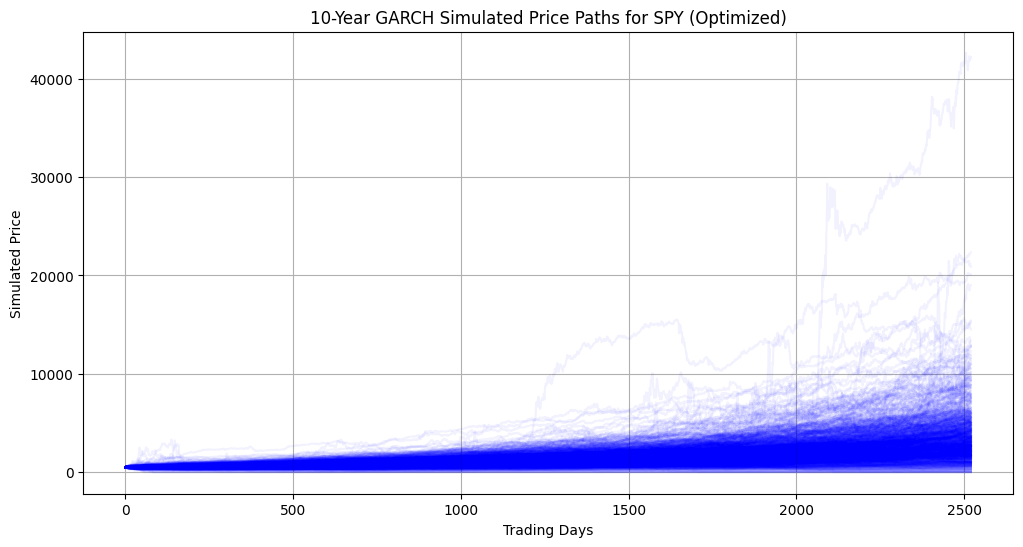

In [ ]:
import yfinance as yf
import numpy as np
import matplotlib.pyplot as plt
from arch import arch_model
from copulas.univariate import StudentTUnivariate

data = yf.download("SPY", start="2010-01-01")["Close"]
returns = 100 * data.pct_change().dropna()

model = arch_model(returns, vol="Garch", p=1, q=1, dist="t")
res = model.fit(disp="off")

standardized_resid = res.resid / res.conditional_volatility
standardized_resid = standardized_resid.dropna()
student_t = StudentTUnivariate()
student_t.fit(standardized_resid.values)

mu = res.params["mu"]
omega = res.params["omega"]
alpha = res.params["alpha[1]"]
beta = res.params["beta[1]"]

n_years = 10
trading_days = 252 * n_years
n_simulations = 1000

last_price = data.iloc[-1]
last_vol = res.conditional_volatility.iloc[-1]
last_resid = res.resid.iloc[-1]

simulated_prices = np.zeros((trading_days + 1, n_simulations))
simulated_prices[0, :] = last_price

eps = np.full(n_simulations, last_resid)
sigma = np.full(n_simulations, last_vol)

for t in range(1, trading_days + 1):
    # z = np.random.normal(size=n_simulations)
    z = student_t.sample(n_simulations)
    sigma2 = omega + alpha * eps**2 + beta * sigma**2
    sigma = np.sqrt(sigma2)
    eps = sigma * z
    r = mu + eps
    simulated_prices[t] = simulated_prices[t - 1] * (1 + r / 100)

plt.figure(figsize=(12, 6))
plt.plot(simulated_prices, alpha=0.05, color="blue")
plt.title("10-Year GARCH Simulated Price Paths for SPY (Optimized)")
plt.xlabel("Trading Days")
plt.ylabel("Simulated Price")
plt.grid(True)
plt.show()


[*********************100%***********************]  3 of 3 completed


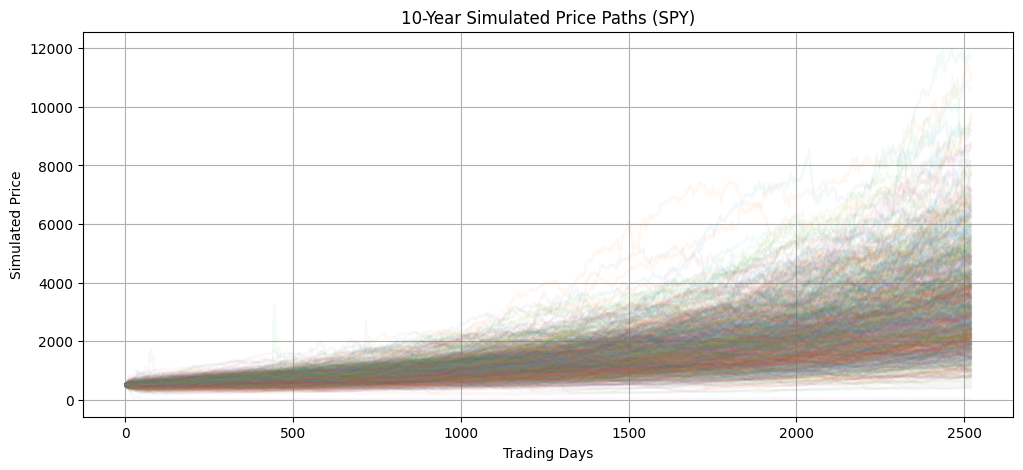

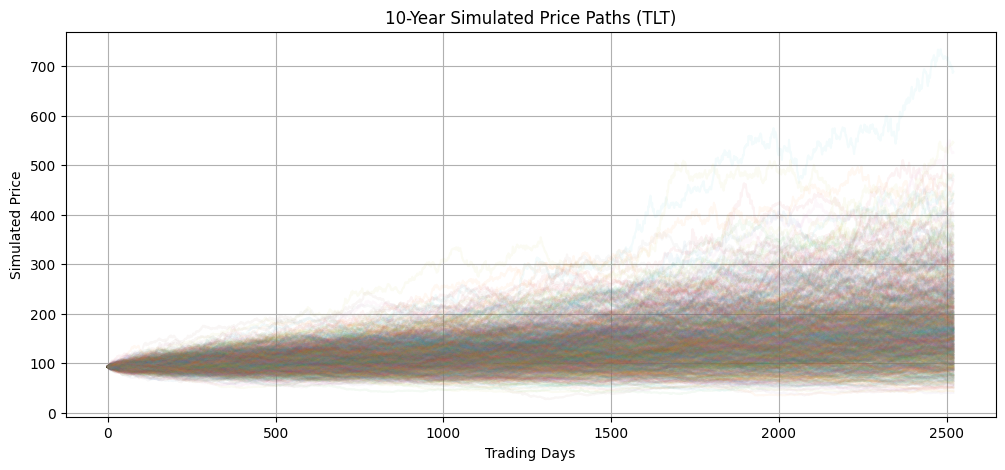

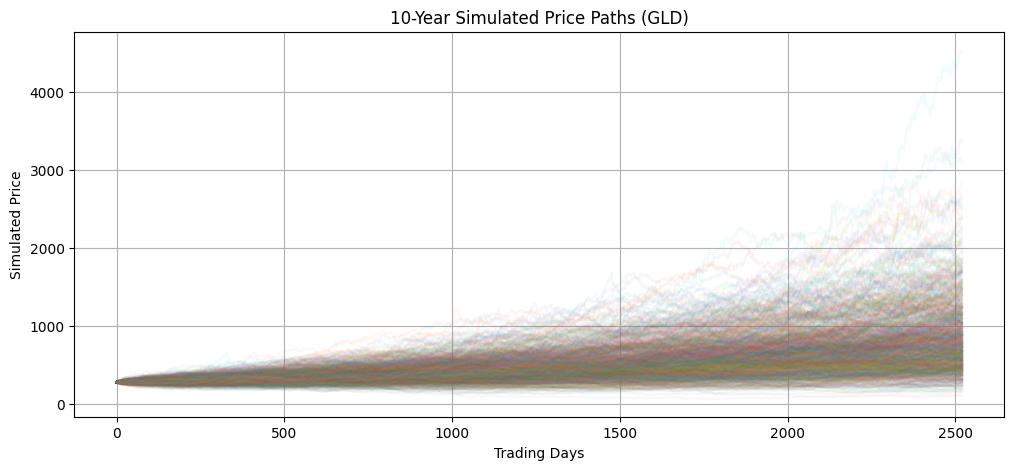

In [18]:
import yfinance as yf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from arch import arch_model
from copulas.univariate import StudentTUnivariate
from copulas.multivariate import GaussianMultivariate
from scipy.stats import norm

# Step 1: Download historical data
symbols = ["SPY", "TLT", "GLD"]
data = yf.download(symbols, start="2010-01-01")["Close"]
returns = 100 * data.pct_change().dropna()

# Step 2: Fit GARCH(1,1) to each asset and get residuals
residuals = {}
vols = {}
models = {}
student_t_models = {}

for sym in symbols:
    model = arch_model(returns[sym], vol="Garch", p=1, q=1, dist="normal")
    res = model.fit(disp="off")
    models[sym] = res
    std_resid = res.resid / res.conditional_volatility
    residuals[sym] = std_resid.dropna()
    vols[sym] = res.conditional_volatility
    t_model = StudentTUnivariate()
    t_model.fit(std_resid.dropna().values)
    student_t_models[sym] = t_model

# Step 3: Fit Gaussian copula to standardized residuals (transformed to uniforms)
uniforms = pd.DataFrame(
    {sym: student_t_models[sym].cdf(residuals[sym]) for sym in symbols}
)
copula = GaussianMultivariate()
copula.fit(uniforms)

# Step 4: Simulation parameters
n_years = 10
trading_days = 252 * n_years
n_simulations = 1000
last_prices = data.iloc[-1]
last_vols = {sym: vols[sym].iloc[-1] for sym in symbols}
last_resids = {sym: models[sym].resid.iloc[-1] for sym in symbols}
omega = {sym: models[sym].params["omega"] for sym in symbols}
alpha = {sym: models[sym].params["alpha[1]"] for sym in symbols}
beta = {sym: models[sym].params["beta[1]"] for sym in symbols}
mu = {sym: models[sym].params["mu"] for sym in symbols}

# Step 5: Simulate price paths
simulated_prices = {sym: np.zeros((trading_days + 1, n_simulations)) for sym in symbols}
for sym in symbols:
    simulated_prices[sym][0, :] = last_prices[sym]

eps = {sym: np.full(n_simulations, last_resids[sym]) for sym in symbols}
sigma = {sym: np.full(n_simulations, last_vols[sym]) for sym in symbols}

# Step 6: Simulate day-by-day with copula + GARCH dynamics
for t in range(1, trading_days + 1):
    # Step 6a: Sample uniform residuals from copula
    u = copula.sample(n_simulations).values  # shape: (n_simulations, 3)

    # Step 6b: Convert uniforms → t residuals and simulate GARCH
    for i, sym in enumerate(symbols):
        z = student_t_models[sym].percent_point(u[:, i])
        sigma2 = omega[sym] + alpha[sym] * eps[sym] ** 2 + beta[sym] * sigma[sym] ** 2
        sigma[sym] = np.sqrt(sigma2)
        eps[sym] = sigma[sym] * z
        r = mu[sym] + eps[sym]
        simulated_prices[sym][t] = simulated_prices[sym][t - 1] * (1 + r / 100)

# Step 7: Plot results for each asset
for sym in symbols:
    plt.figure(figsize=(12, 5))
    plt.plot(simulated_prices[sym], alpha=0.05)
    plt.title(f"10-Year Simulated Price Paths ({sym})")
    plt.xlabel("Trading Days")
    plt.ylabel("Simulated Price")
    plt.grid(True)
    plt.show()
